# THIS FILE IS USELESS, ONLY TO TRY METHODS

In [ ]:
import sys
import os

# Add the parent folder of the notebook (src/) to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from regression_sampler import RegressionSamplerSingle
import numpy as np
from sklearn.linear_model import LassoCV



n = 1000
p = 30
X = np.random.normal(size=(n,1)) * 0.5 + np.random.normal(size=(n,p)) * 0.5
beta = np.random.normal(size=4)
Y = np.random.normal(X[:,1:1+len(beta)].dot(beta))
    
# Create train/test splits
X_train, Y_train = X[:900], Y[:900]
X_test, Y_test = X[900:], Y[900:]


# Simple OLS regression
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X_train, Y_train)

# Evaluate the first feature
feature = 0

sampler = RegressionSamplerSingle(
    estimator=LassoCV(alphas=np.logspace(-3, 3, 10), cv=5, random_state=1),
    X_train=X_train,
    X_test=X_test,
    covariate_index=feature
)
sampler.fit()

def conditional(X_eval=None):
    sample = sampler.sampler().ravel()  # shape (n_test,)
    # HRT expects length(len(lower)+len(upper)) -> here 2
    probs = np.ones(2)                   # dummy CI
    return sample, probs


tstat_fn = lambda X_eval: ((Y_test - model.predict(X_eval))**2).mean()

from pyhrt.hrt import hrt
results = hrt(
    feature,
    tstat_fn,
    X_train,
    X_test=X_test,
    conditional=conditional
)

print(results['p_value'])



    

In [1]:
import numpy as np
import torch



n = 1000
p = 30
X = np.random.normal(size=(n,1)) * 0.5 + np.random.normal(size=(n,p)) * 0.5
beta = np.random.normal(size=4)
Y = np.random.normal(X[:,1:1+len(beta)].dot(beta))

# Create train/test splits
X_train, Y_train = X[:900], Y[:900]
X_test, Y_test = X[900:], Y[900:]

# Simple OLS regression
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X_train, Y_train)

# Evaluate the first feature
feature = 0

# Use mean squared error as the empirical risk metric
tstat_fn = lambda X_eval: ((Y_test - model.predict(X_eval))**2).mean()

# Run the HRT
from pyhrt.hrt import hrt
results = hrt(feature, tstat_fn, X_test, conditional)

# Print the p-value
print(results['p_value'])

Using training set as testing set.
Fitting using 100 bootstrap resamples and a 100/100 train/test split
	Bootstrap 0


/scratch/areyerol/loss_KO/loss_based_KO/hrt/pyhrt/continuous.py:197: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(tmp_file)


	Bootstrap 1
	Bootstrap 2
	Bootstrap 3
	Bootstrap 4
	Bootstrap 5
	Bootstrap 6
	Bootstrap 7
	Bootstrap 8
	Bootstrap 9
	Bootstrap 10
	Bootstrap 11
	Bootstrap 12
	Bootstrap 13
	Bootstrap 14
	Bootstrap 15
	Bootstrap 16
	Bootstrap 17
	Bootstrap 18
	Bootstrap 19
	Bootstrap 20
	Bootstrap 21
	Bootstrap 22
	Bootstrap 23
	Bootstrap 24
	Bootstrap 25
	Bootstrap 26
	Bootstrap 27
	Bootstrap 28
	Bootstrap 29
	Bootstrap 30
	Bootstrap 31
	Bootstrap 32
	Bootstrap 33
	Bootstrap 34
	Bootstrap 35
	Bootstrap 36
	Bootstrap 37
	Bootstrap 38
	Bootstrap 39
	Bootstrap 40
	Bootstrap 41
	Bootstrap 42
	Bootstrap 43
	Bootstrap 44
	Bootstrap 45
	Bootstrap 46
	Bootstrap 47
	Bootstrap 48
	Bootstrap 49
	Bootstrap 50
	Bootstrap 51
	Bootstrap 52
	Bootstrap 53
	Bootstrap 54
	Bootstrap 55
	Bootstrap 56
	Bootstrap 57
	Bootstrap 58
	Bootstrap 59
	Bootstrap 60
	Bootstrap 61
	Bootstrap 62
	Bootstrap 63
	Bootstrap 64
	Bootstrap 65
	Bootstrap 66
	Bootstrap 67
	Bootstrap 68
	Bootstrap 69
	Bootstrap 70
	Bootstrap 71
	Bootstrap 72
	

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV

from hidimstat import D0CRT
from hidimstat._utils.scenario import multivariate_simulation

In [4]:
results_list = []
for sim_ind in range(10):
    print(f"Processing: {sim_ind+1}")

    # Number of observations
    n = 100
    # Number of variables
    p = 10
    # Number of relevant variables
    n_signal = 2
    # Signal-to-noise ratio
    signal_noise_ratio = 4
    # Correlation coefficient
    rho = 0.8
    # Nominal false positive rate
    alpha = 5e-2

    X, y, beta_true, noise = multivariate_simulation(
        n_samples=n,
        n_features=p,
        support_size=n_signal,
        rho=rho,
        signal_noise_ratio=signal_noise_ratio,
        shuffle=True,
        seed=sim_ind,
    )

    # Applying a reLu function on the outcome y to get non-linear relationships
    y = np.maximum(0.0, y)

    ## dcrt Lasso ##
    d0crt_lasso = D0CRT(
        estimator=LassoCV(random_state=sim_ind, n_jobs=1),
        screening_threshold=None,
        random_state=sim_ind,
    )
    d0crt_lasso.fit_importance(X, y)
    pvals_lasso = d0crt_lasso.pvalues_
    results_list.append(
        {
            "model": "Lasso",
            "type-1 error": sum(pvals_lasso[np.logical_not(beta_true)] < alpha)
            / (p - n_signal),
            "power": sum(pvals_lasso[beta_true] < alpha) / (n_signal),
        }
    )

    ## dcrt Random Forest ##
    d0crt_random_forest = D0CRT(
        estimator=RandomForestRegressor(
            n_estimators=100, random_state=sim_ind, n_jobs=1
        ),
        screening_threshold=None,
        random_state=sim_ind,
    )
    d0crt_random_forest.fit_importance(X, y)
    pvals_forest = d0crt_random_forest.pvalues_
    results_list.append(
        {
            "model": "RF",
            "type-1 error": sum(pvals_forest[np.logical_not(beta_true)] < alpha)
            / (n_signal),
            "power": sum(pvals_forest[beta_true] < alpha) / (n_signal),
        }
    )


Processing: 1
Processing: 2
Processing: 3
Processing: 4
Processing: 5
Processing: 6
Processing: 7
Processing: 8
Processing: 9
Processing: 10


In [6]:
pvals_forest

array([4.12668113e-02, 2.31087860e-01, 8.98612920e-02, 1.59149310e-01,
       2.08023968e-01, 7.82968938e-01, 4.61040700e-07, 7.84614868e-01,
       4.63340657e-02, 8.87118450e-01])

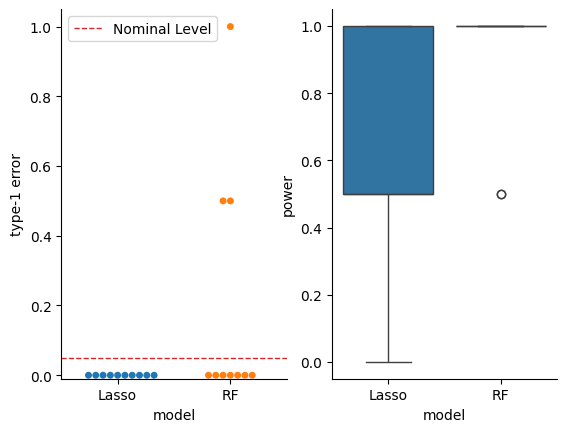

In [5]:
df_plot = pd.DataFrame(results_list)

_, ax = plt.subplots(nrows=1, ncols=2)
sns.swarmplot(data=df_plot, x="model", y="type-1 error", ax=ax[0], hue="model")
ax[0].axhline(
    alpha,
    linewidth=1,
    color="tab:red",
    ls="--",
    label="Nominal Level",
)
ax[0].legend()
ax[0].set_ylim(-0.01)

sns.boxplot(data=df_plot, x="model", y="power", ax=ax[1], hue="model")

sns.despine()
plt.show()

In [49]:
from hidimstat.knockoffs import model_x_knockoff
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold

from hidimstat._utils.scenario import multivariate_simulation
from hidimstat.knockoffs import (
    model_x_knockoff,
    model_x_knockoff_bootstrap_e_value,
    model_x_knockoff_bootstrap_quantile,
    model_x_knockoff_pvalue,
)
from hidimstat.statistical_tools.multiple_testing import fdp_power


# number of repetitions of he methods
runs = 20
# Number of observations
n_samples = 200
# Number of variables
n_features = 150
# Correlation parameter
rho = 0.5
# Ratio of number of variables with non-zero coefficients over total
# coefficients
sparsity = 0.2
# Desired controlled False Discovery Rate (FDR) level
fdr = 0.1
# signal noise ration
signal_noise_ratio = 10
# number of repetitions for the bootstraps
n_bootstraps = 25
# number of jobs for repetition of the method
n_jobs = 2
# verbosity of the joblib
joblib_verbose = 0
# Define the seeds for the reproducibility of the example
rng = np.random.default_rng(42)


In [50]:
def single_run(
    n_samples,
    n_features,
    rho,
    sparsity,
    signal_noise_ratio,
    fdr,
    n_bootstraps,
    seed=None,
):
    # Generate data
    X, y, beta_true, noise = multivariate_simulation(
        n_samples,
        n_features,
        rho=rho,
        support_size=int(n_features * sparsity),
        signal_noise_ratio=signal_noise_ratio,
        seed=seed,
    )
    non_zero_index = np.where(beta_true)[0]

    # Use model-X Knockoffs [1]
    selected, test_scores, threshold, X_tildes = model_x_knockoff(
        X,
        y,
        estimator=LassoCV(
            n_jobs=1,
            cv=KFold(n_splits=5, shuffle=True, random_state=0),
            random_state=1,
        ),
        n_bootstraps=1,
        random_state=2,
    )
    mx_selection, _ = model_x_knockoff_pvalue(test_scores, fdr=fdr)
    fdp_mx, power_mx = fdp_power(selected, non_zero_index)

    # Use aggregation model-X Knockoffs [2]
    selected, test_scores, threshold, X_tildes = model_x_knockoff(
        X,
        y,
        estimator=LassoCV(
            n_jobs=1,
            cv=KFold(n_splits=5, shuffle=True, random_state=3),
            random_state=4,
        ),
        n_bootstraps=n_bootstraps,
        n_jobs=1,
        random_state=5,
    )

    # Use p-values aggregation [2]
    aggregated_ko_selection, _, _ = model_x_knockoff_bootstrap_quantile(
        test_scores, fdr=fdr, adaptive_aggregation=True
    )

    fdp_pval, power_pval = fdp_power(aggregated_ko_selection, non_zero_index)

    # Use e-values aggregation [3]
    eval_selection, _, _ = model_x_knockoff_bootstrap_e_value(
        test_scores, threshold, fdr=fdr
    )

    fdp_eval, power_eval = fdp_power(eval_selection, non_zero_index)

    return fdp_mx, fdp_pval, fdp_eval, power_mx, power_pval, power_eval

In [51]:
def plot_results(bounds, fdr, n_samples, n_features, power=False):
    plt.figure(figsize=(5, 5), layout="constrained")
    for nb in range(len(bounds)):
        for i in range(len(bounds[nb])):
            y = bounds[nb][i]
            x = rng.normal(nb + 1, 0.05)
            plt.scatter(x, y, alpha=0.65, c="blue")

    plt.boxplot(bounds, sym="")
    if power:
        plt.xticks(
            [1, 2, 3],
            ["MX Knockoffs", "Quantile aggregation", "e-values aggregation"],
            rotation=45,
            ha="right",
        )
        plt.title(f"FDR = {fdr}, n = {n_samples}, p = {n_features}")
        plt.ylabel("Empirical Power")

    else:
        plt.hlines(fdr, xmin=0.5, xmax=3.5, label="Requested FDR control", color="red")
        plt.xticks(
            [1, 2, 3],
            ["MX Knockoffs", "Quantile aggregation", "e-values aggregation"],
            rotation=45,
            ha="right",
        )
        plt.title(f"FDR = {fdr}, n = {n_samples}, p = {n_features}")
        plt.ylabel("Empirical FDP")
        plt.legend(loc="best")

In [52]:
def effect_number_samples(n_samples):
    parallel = Parallel(n_jobs, verbose=joblib_verbose)
    results = parallel(
        delayed(single_run)(
            n_samples,
            n_features,
            rho,
            sparsity,
            signal_noise_ratio,
            fdr,
            n_bootstraps,
            seed=seed,
        )
        for seed in range(runs)
    )

    fdps_mx = []
    fdps_pval = []
    fdps_eval = []
    powers_mx = []
    powers_pval = []
    powers_eval = []
    for fdp_mx, fdp_pval, fdp_eval, power_mx, power_pval, power_eval in results:
        fdps_mx.append(fdp_mx)
        fdps_pval.append(fdp_pval)
        fdps_eval.append(fdp_eval)

        powers_mx.append(power_mx)
        powers_pval.append(power_pval)
        powers_eval.append(power_eval)

    # Plot FDP and Power distributions

    fdps = [fdps_mx, fdps_pval, fdps_eval]
    powers = [powers_mx, powers_pval, powers_eval]

    plot_results(fdps, fdr, n_samples, n_features)
    plot_results(powers, fdr, n_samples, n_features, power=True)
    plt.show()

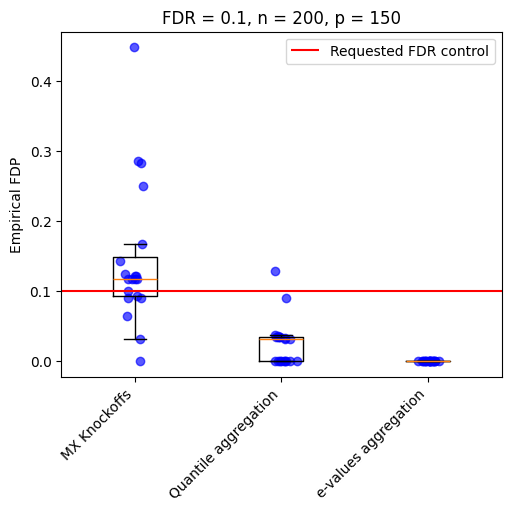

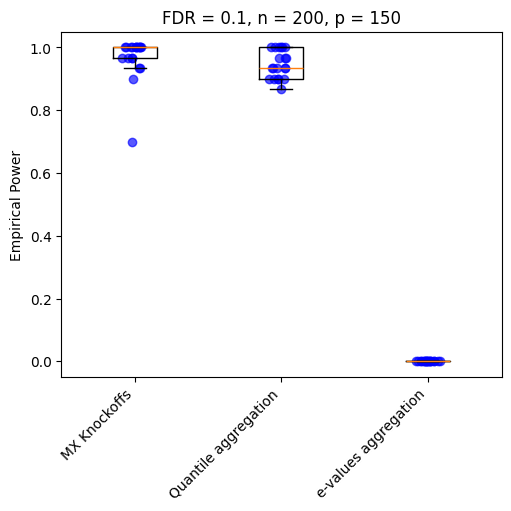

In [53]:
effect_number_samples(n_samples=n_samples)

In [16]:
from sklearn.preprocessing import PolynomialFeatures

def ind(i,j,k):
    # separates &,n into k blocks
    return int(i//k==j//k)
# One Toeplitz matrix  
def toep (d, rho=0.6):
  return np.array([[ (rho)**abs(i-j) for i in range(d)]for j in range(d)])


def simu_data(n, p, rho=0.25, snr=2.0, sparsity=0.06, effect=1.0, seed=None):
    """Function to simulate data follow an autoregressive structure with Toeplitz
    covariance matrix.
    Adapted from hidimstat: https://github.com/ja-che/hidimstat

    Parameters
    ----------
    n : int
        number of observations
    p : int
        number of variables
    sparsity : float, optional
        ratio of number of variables with non-zero coefficients over total
        coefficients
    rho : float, optional
        correlation parameter
    effect : float, optional
        signal magnitude, value of non-null coefficients
    seed : None or Int, optional
        random seed for generator

    Returns
    -------
    X : ndarray, shape (n, p)
        Design matrix resulted from simulation
    y : ndarray, shape (n, )
        Response vector resulted from simulation
    beta_true : ndarray, shape (n, )
        Vector of true coefficient value
    non_zero : ndarray, shape (n, )
        Vector of non zero coefficients index

    """
    # Setup seed generator
    rng = np.random.default_rng(seed)

    # Number of non-null
    k = int(sparsity * p)

    # Generate the variables from a multivariate normal distribution
    mu = np.zeros(p)
    Sigma = toeplitz(rho ** np.arange(0, p))  # covariance matrix of X
    # X = np.dot(np.random.normal(size=(n, p)), cholesky(Sigma))
    X = rng.multivariate_normal(mu, Sigma, size=(n))
    # Generate the response from a linear model
    blob_indexes = np.linspace(0, p - 6, int(k/5), dtype=int)
    non_zero = np.array([np.arange(i, i+5) for i in blob_indexes])
    # non_zero = rng.choice(p, k, replace=False)
    beta_true = np.zeros(p)
    beta_true[non_zero] = effect
    eps = rng.standard_normal(size=n)
    prod_temp = np.dot(X, beta_true)
    noise_mag = np.linalg.norm(prod_temp) / (snr * np.linalg.norm(eps))
    y = prod_temp + noise_mag * eps

    return X, y, beta_true, non_zero, Sigma



def GenToysDataset(n=1000, d=10, cor='toep', y_method="nonlin", k=2, mu=None, rho_toep=0.6, sparsity=0.1, seed=0, snr=2):
    """
    Generate a synthetic toy dataset for regression tasks.

    Parameters:
    -----------
    n : int, optional (default=1000)
        Number of samples.
    d : int, optional (default=10)
        Number of features.
    cor : str, optional (default='toep')
        Type of correlation among features. Options:
        - 'iso': Isotropic normal distribution.
        - 'cor': Correlated features using matrix U.
        - 'toep': Toeplitz covariance structure.
    y_method : str, optional (default='nonlin')
        Method for generating target variable y. Options:
        - 'williamson': Quadratic function of first two features.
        - 'hidimstats': High-dimensional sparse regression.
        - 'nonlin': Nonlinear interaction of first five features.
        - 'nonlin2': Extended nonlinear interactions with additional terms.
        - 'lin': Linear combination of first two features.
        - 'poly': Polynomial interactions of randomly selected features.
    k : int, optional (default=2)
        Parameter for correlation matrix U when cor='cor'.
    mu : array-like or None, optional (default=None)
        Mean vector for multivariate normal distribution.
    rho_toep : float, optional (default=0.6)
        Correlation coefficient for Toeplitz covariance matrix.
    sparsity : float, optional (default=0.1)
        Proportion of nonzero coefficients in high-dimensional regression.
    seed : int, optional (default=0)
        Random seed for reproducibility.
    snr : float, optional (default=2)
        Signal-to-noise ratio for high-dimensional regression.

    Returns:
    --------
    X : ndarray of shape (n, d)
        Feature matrix.
    y : ndarray of shape (n,)
        Target variable.
    true_imp : ndarray of shape (d,)
        Binary array indicating which features are truly important.
    """
    np.random.seed(seed)
    true_imp = np.zeros(d)
    
    if y_method == "williamson":
        X1, X2 = np.random.uniform(-1, 1, (2, n))
        X = np.column_stack((X1, X2))
        y = (25/9) * X1**2 + np.random.normal(0, 1, n)
        return X, y, np.array([1, 0])
    
    if y_method == "hidimstats":
        X, y, _, non_zero_index, _ = simu_data(n, d, rho=rho_toep, sparsity=sparsity, seed=seed, snr=snr)
        true_imp[non_zero_index] = 1
        return X, y, true_imp
    
    mu = np.zeros(d) if mu is None else mu
    X = np.zeros((n, d))
    
    if cor == 'iso':
        X = np.random.normal(size=(n, d))
    elif cor == 'cor':
        U = np.array([[ind(i, j, k) for j in range(d)] for i in range(d)]) / np.sqrt(k)
        X = np.random.normal(size=(n, d)) @ U + mu
    elif cor == 'toep':
        X = np.random.multivariate_normal(mu, toep(d, rho_toep), size=n)
    else:
        raise ValueError("Invalid correlation type. Choose from 'iso', 'cor', or 'toep'.")
    
    if y_method == "nonlin":
        y = X[:, 0] * X[:, 1] * (X[:, 2] > 0) + 2 * X[:, 3] * X[:, 4] * (X[:, 2] <= 0)
        true_imp[:5] = 1
    elif y_method == "nonlin2":
        y = (X[:, 0] * X[:, 1] * (X[:, 2] > 0) + 2 * X[:, 3] * X[:, 4] * (X[:, 2] <= 0)
             + X[:, 5] * X[:, 6] / 2 - X[:, 7]**2 + X[:, 9] * (X[:, 8] > 0))
        true_imp[:10] = 1
    elif y_method == "lin":
        y = 2 * X[:, 0] + X[:, 1]
        true_imp[:2] = 1
    elif y_method == "poly":
        rng = np.random.RandomState(seed)
        non_zero_index = rng.choice(d, int(sparsity * d), replace=False)
        poly_transformer = PolynomialFeatures(degree=3, interaction_only=True)
        features = poly_transformer.fit_transform(X[:, non_zero_index])
        coef_features = np.random.choice([-1, 1], features.shape[1])
        y = np.dot(features, coef_features)
        true_imp[non_zero_index] = 1
    else:
        raise ValueError("Invalid y_method. Choose from 'williamson', 'hidimstats', 'nonlin', 'nonlin2', 'lin', or 'poly'.")
    
    return X, y, true_imp

In [17]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import ElasticNetCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Base learners
estimators = [
    ('enet', ElasticNetCV(l1_ratio=[.1, .5, .9], alphas=[1e-3, 1e-2, 1e-1, 1], cv=5, n_jobs=-1)),
    ('ridge', RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])),
    ('rf', RandomForestRegressor(n_estimators=300, max_depth=10, random_state=0, n_jobs=-1)),
    ('gbr', GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=0)),
    ('xgb', XGBRegressor(objective='reg:squarederror', n_estimators=300, learning_rate=0.05, max_depth=3, n_jobs=-1, random_state=0)),
    ('lgbm', LGBMRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=0, n_jobs=-1))
]

# Meta-learner
final_estimator = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])

sl = StackingRegressor(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    n_jobs=-1
)


In [46]:
from sklearn.model_selection import GridSearchCV, train_test_split
import numpy as np

ntrees = np.arange(100, 300, 100)
lr = np.arange(.01, .1, .05)
param_grid = [{'n_estimators':ntrees, 'learning_rate':lr}]
gb = GridSearchCV(GradientBoostingRegressor(loss = 'squared_error', max_depth = 3), param_grid = param_grid, cv = 3, n_jobs=-1)


In [47]:
n=500
p=100
X, y, true_imp = GenToysDataset(n=n, d=p, y_method='poly', rho_toep=0.6, sparsity=0.25, seed=1, snr=2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


In [48]:
gb.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid=[{'learning_rate': array([0.01, 0.06]),
                          'n_estimators': array([100, 200])}])

In [43]:
sl.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11771
[LightGBM] [Info] Number of data points in the train set: 350, number of used features: 100
[LightGBM] [Info] Start training from score 3.978566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/home/mind/areyerol/.local/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/mind/areyerol/.local/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/mind/areyerol/.local/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/mind/areyerol/.local/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/mind/areyerol/.local/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


StackingRegressor(cv=5,
                  estimators=[('enet',
                               ElasticNetCV(alphas=[0.001, 0.01, 0.1, 1], cv=5,
                                            l1_ratio=[0.1, 0.5, 0.9],
                                            n_jobs=-1)),
                              ('ridge', RidgeCV(alphas=[0.001, 0.01, 0.1, 1])),
                              ('rf',
                               RandomForestRegressor(max_depth=10,
                                                     n_estimators=300,
                                                     n_jobs=-1,
                                                     random_state=0)),
                              ('gbr',
                               GradientBoostingRegressor(learning_rate=0.05,
                                                         n_estimators=300,
                                                         random_state=0)),
                              ('xgb',
                               XGBRe...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=-1,
                                            num_parallel_tree=None, ...)),
                              ('lgbm',
                               LGBMRegressor(learning_rate=0.05, max_depth=3,
                                             n_estimators=300, n_jobs=-1,
                                             random_state=0))],
                  final_estimator=RidgeCV(alphas=[0.001, 0.01, 0.1, 1]),
                  n_jobs=-1)

In [44]:
((y_test - gb.predict(X_test))**2).mean()

np.float64(3088.066953866802)

In [45]:
((y_test - sl.predict(X_test))**2).mean()

/home/mind/areyerol/.local/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


np.float64(2919.4010568739836)